In [1]:
%pip install pydub

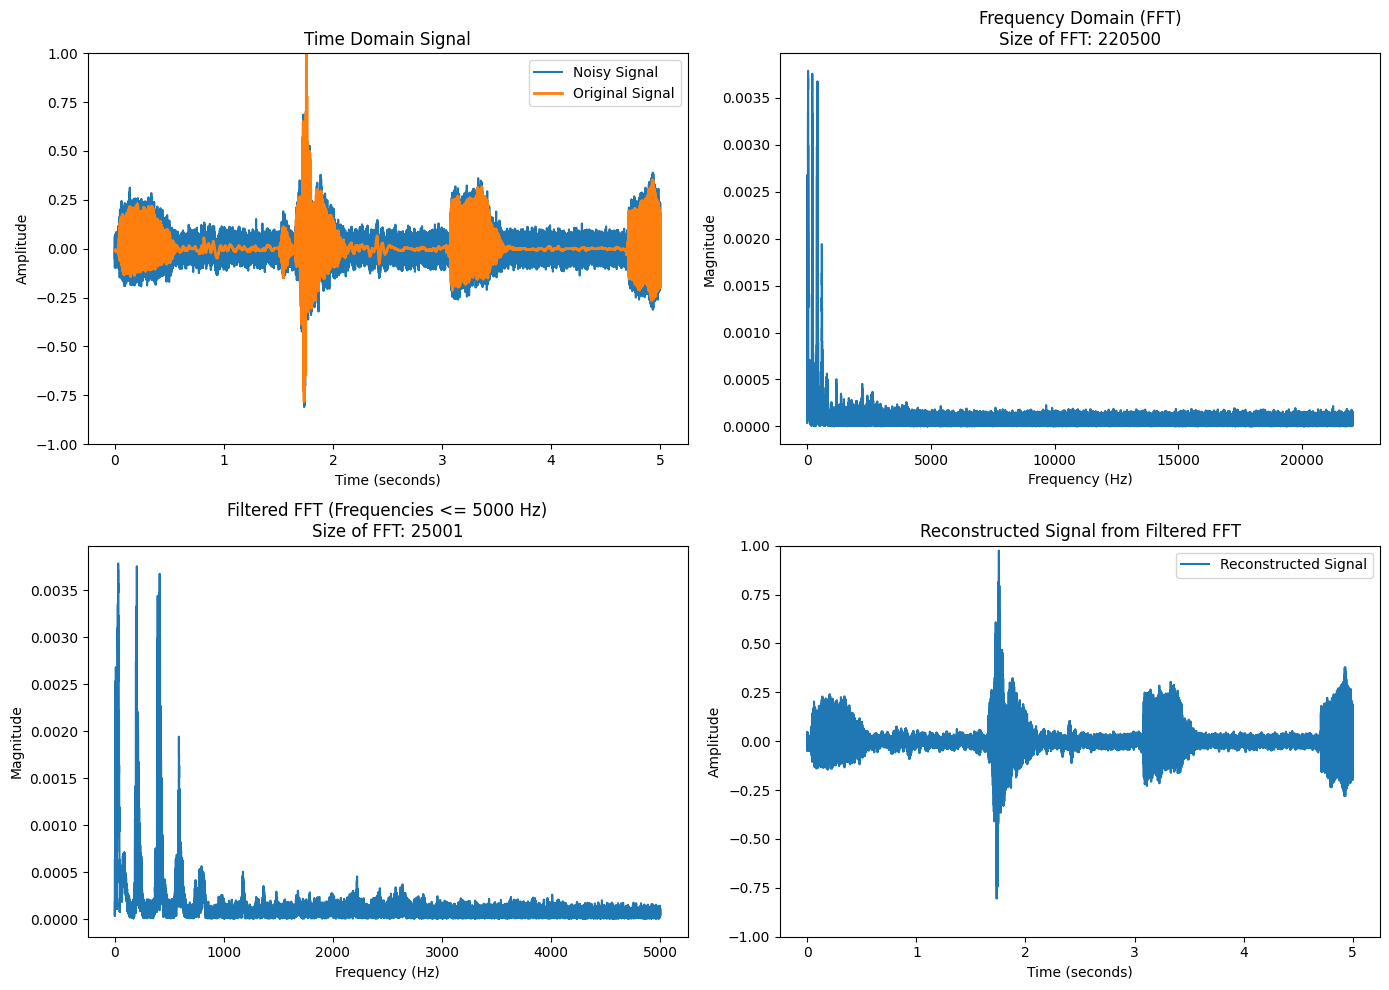

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from pydub import AudioSegment
import requests
import os

# URL of the MP3 file (public domain sample from LibriVox), ~60 MB
# url = "https://ia800208.us.archive.org/7/items/adventures_holmes/adventureholmes_01_doyle.mp3"

# Short mp3 public domain (Female Counts To Ten), ~174 KB
url = "http://soundbible.com/grab.php?id=175&type=mp3"
mp3_filename = "sample.mp3"
wav_filename = "sample.wav"

if not os.path.exists(mp3_filename) or not os.path.exists(wav_filename):
    # Download the MP3 file
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(mp3_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    # Convert MP3 to WAV (requires pydub and ffmpeg)
    audio = AudioSegment.from_mp3(mp3_filename)
    audio.export(wav_filename, format="wav")

# Read the WAV file
Fs, signal = wavfile.read(wav_filename)

# Ensure signal is mono (single channel)
if len(signal.shape) > 1:
    signal = signal[:, 0]

# Normalize signal
signal = signal / np.max(np.abs(signal))

# Limit the signal to a specific number of seconds
duration_seconds = 5  # Change this value to limit the duration
num_samples = int(Fs * duration_seconds)
signal = signal[:num_samples]

# Define the length of the signal and the time vector
L = len(signal)
T = 1 / Fs
t = np.arange(0, L) * T

# Add some noise to the signal for demonstration purposes
noise = 0.03 * np.random.normal(size=t.shape)
signal_noisy = signal + noise

# Compute the FFT
signal_fft = np.fft.fft(signal_noisy)
frequencies = np.fft.fftfreq(L, T)

# Take the magnitude of the FFT and only keep the positive frequencies
signal_magnitude = np.abs(signal_fft / L)
positive_frequencies = frequencies[:L//2]
signal_magnitude = signal_magnitude[:L//2]

# Filter the FFT by setting values with magnitude less than 0.1 to zero
# threshold = 0.0002
# filtered_fft = np.copy(signal_fft)
# filtered_fft[np.abs(signal_fft / L) < threshold] = 0

# Filter the FFT by keeping only frequencies <= 5000 Hz
cutoff_frequency = 5000
filtered_fft = np.copy(signal_fft)
filtered_fft[np.abs(frequencies) > cutoff_frequency] = 0

# Only keep the positive frequencies and non-zero elements
filtered_fft_positive = filtered_fft[:L//2]
non_zero_indices = np.where(np.abs(filtered_fft_positive) > 0)[0]
filtered_fft_positive = filtered_fft_positive[non_zero_indices]
frequencies_filtered = positive_frequencies[non_zero_indices]

# Reconstruct the signal using the filtered FFT
filtered_fft_full = np.zeros_like(signal_fft)
filtered_fft_full[:L//2][non_zero_indices] = filtered_fft_positive
filtered_fft_full[-L//2:][non_zero_indices] = np.conj(filtered_fft_positive[::-1])
reconstructed_signal = np.fft.ifft(filtered_fft_full)

# Calculate the maximum amplitude for fixed scaling
max_amplitude = max(np.max(np.abs(signal_noisy)), np.max(np.abs(signal)))

# Plot the original signal
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(t, signal_noisy, label='Noisy Signal')
plt.plot(t, signal, label='Original Signal', linewidth=2)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.ylim([-max_amplitude, max_amplitude])
plt.title('Time Domain Signal')
plt.legend()

# Plot the FFT magnitude
plt.subplot(2, 2, 2)
plt.plot(positive_frequencies, signal_magnitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title(f'Frequency Domain (FFT)\nSize of FFT: {len(signal_fft)}')

# Plot the filtered FFT magnitude
filtered_magnitude = np.abs(filtered_fft_positive / L)
plt.subplot(2, 2, 3)
plt.plot(frequencies_filtered, filtered_magnitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
# plt.title(f'Filtered FFT (Threshold > {threshold})\nSize of FFT: {len(filtered_fft_positive)}')
plt.title(f'Filtered FFT (Frequencies <= {cutoff_frequency} Hz)\nSize of FFT: {len(filtered_fft_positive)}')

# Plot the reconstructed signal
plt.subplot(2, 2, 4)
plt.plot(t, np.real(reconstructed_signal), label='Reconstructed Signal')
# plt.plot(t, signal, label='Original Signal', linewidth=2)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.ylim([-max_amplitude, max_amplitude])
plt.title('Reconstructed Signal from Filtered FFT')
plt.legend()

plt.tight_layout()
plt.show()
